In [79]:
import numpy as np
import re
import math
import random
import matplotlib.pyplot as plt

In [80]:
def import_data():
    data = []
    with open('file-tsp.txt') as f:
        for line in f:
            cords = re.split('\s+', line)
            data.append([float(cords[0]),float(cords[1])])
    return data

data = import_data()

In [81]:
def dist(city1, city2):
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city1[1]))

In [82]:
distance_matrix = np.zeros((50,50))

for i, city1 in enumerate(data):
    for j, city2 in enumerate(data):
        distance_matrix[i,j] = dist(city1, city2)


In [83]:
print(distance_matrix)

[[ 0.      0.1785  0.4823 ... 18.1404 18.7142 18.8374]
 [ 0.1785  0.      0.3038 ... 17.9619 18.5357 18.6589]
 [ 0.4823  0.3038  0.     ... 17.6581 18.2319 18.3551]
 ...
 [18.1404 17.9619 17.6581 ...  0.      0.5738  0.697 ]
 [18.7142 18.5357 18.2319 ...  0.5738  0.      0.1232]
 [18.8374 18.6589 18.3551 ...  0.697   0.1232  0.    ]]


In [84]:
def fitness(sequence):
    total_distance = 0
    for i in range(1,len(sequence)):
        total_distance += distance_matrix[sequence[i], sequence[i-1]]

    # In the slides 1/total_distance is used, this often gives a very small floating number
    return total_distance

def tsp_crossover(parent1, parent2):
    cutoff = sorted(random.sample(range(1,len(parent1)), 2))

    middle_p1 = parent1[cutoff[0]:cutoff[1]]
    middle_p2 = parent2[cutoff[0]:cutoff[1]]

    complement_p1 = parent1.copy()
    complement_p2 = parent2.copy()

    for x in middle_p1:
        complement_p2.remove(x)

    for x in middle_p2:
        complement_p1.remove(x)
    
    cutoff_complement = len(parent1) - cutoff[0]

    child1 = complement_p2[cutoff_complement:] + middle_p1 + complement_p2[:cutoff_complement] 
    child2 = complement_p1[cutoff_complement:] + middle_p2 + complement_p1[:cutoff_complement]

    return child1, child2

def tsp_mutation(parent):
    i1, i2 = random.sample(range(len(parent)), 2)
    parent[i1], parent[i2] = parent[i2], parent[i1]
    return parent

def swap_2opt(parent, i1, i2):
    middle = parent[i1:i2+1]
    middle.reverse()
    return parent[:i1] + middle + parent[i2+1:]

def determine_new_route(route):
    best_distance = fitness(route)

    for i in range(0,len(route)-1):
        for j in range(1, len(route)):
            new_route = swap_2opt(route, i, j)
            new_distance = fitness(new_route)

            if new_distance < best_distance:
                return new_route, new_distance
    
    return None, best_distance


In [107]:
N = 50
K = 2
mutation_rate = 0.01
generations = 1500

def TSP():
    # Create population
    population = []
    distances = []
    for _ in range(N):
        population.append(np.random.permutation(50).tolist())

    for _ in range(generations):
        # Tournament selection
        parents = []
        indexes = np.random.permutation(len(population))
        for x, y in zip(*[iter(indexes)]*2):
            fitness_x = fitness(population[x])
            fitness_y = fitness(population[y])
            parents.append(x) if fitness_x < fitness_y else parents.append(y)
        
        # Roll the parents over by 1 such that we get pairs of parents
        parents_1 = np.roll(np.array(parents), 1)

        new_population = []
        min_distance = 100000000

        # Perform the crossover and select the top 2 routes
        for i in range(len(parents)):
            parent_1 = population[parents[i]]
            parent_2 = population[parents_1[i]]

            child1, child2 = tsp_crossover(parent_1, parent_2)
            
            elements = [(fitness(parent_1), parent_1), (fitness(parent_2), parent_2), (fitness(child1), child1), (fitness(child2), child2)]
            top_elements = sorted(elements)[:2]
            new_population.append(top_elements[0][1])
            new_population.append(top_elements[1][1])
            min_distance = min(min_distance, top_elements[0][0])
        

        # Perform the mutation according to an elitist scheme
        for x in new_population:
            if random.random() < mutation_rate:
                y = tsp_mutation(x.copy())
                new_fitness = fitness(y)
                if new_fitness < fitness(x):
                    x = y
                    if new_fitness < min_distance:
                        min_distance = new_fitness

        population = new_population
        distances.append(min_distance)  
    return distances

def TSP_2opt_one_parent():
    # Create population
    route = np.random.permutation(50).tolist()
    distances = []

    best_distance = fitness(route)
    distances.append(best_distance)

    for _ in range(generations):
        new_route, best_distance = determine_new_route(route)
        distances.append(best_distance)
        if new_route == None:
            break

        route = new_route
    return distances

def TSP_2opt():
    population = []
    distances  = []

    # Create population
    for _ in range(N):
        population.append(np.random.permutation(50).tolist())
    
    for route in population:
        route, best_distance = determine_new_route(route)

    for _ in range(generations):
        parents = []
        temp_population = []
        # Apply local search once to each individual route
        for route in population:
            new_route, _ = determine_new_route(route)
            temp_population += [new_route, route]

        population += temp_population


        # Tournament selection
        indexes = np.random.permutation(len(population))
        for x, y in zip(*[iter(indexes)]*2):
            fitness_x = fitness(population[x])
            fitness_y = fitness(population[y])
            parents.append(x) if fitness_x < fitness_y else parents.append(y)

        parents_1 = np.roll(np.array(parents), 1)

        new_population = []
        min_distance = 100000000

        # Perform the crossover and select the top route
        for i in range(len(parents)):
            parent_1 = population[parents[i]]
            parent_2 = population[parents_1[i]]

            child1, child2 = tsp_crossover(parent_1, parent_2)
            
            elements = [(fitness(parent_1), parent_1), (fitness(parent_2), parent_2), (fitness(child1), child1), (fitness(child2), child2)]
            top_elements = sorted(elements)[:2]
            new_population.append(top_elements[0][1])
            min_distance = min(min_distance, top_elements[0][0])
        
        # Perform the mutation according to an elitist scheme
        for x in new_population:
            if random.random() < mutation_rate:
                y = tsp_mutation(x.copy())
                new_fitness = fitness(y)
                if new_fitness < fitness(x):
                    x = y
                    if new_fitness < min_distance:
                        min_distance = new_fitness

        population = new_population
        distances.append(min_distance)
        print(min_distance)

        # Implemented stop criterion to reduce runtime (known best value)
        if min_distance == 18.8374:
            return distances   
    return distances

TSP_2opt()
        

322.1532000000001
308.84999999999997
302.4851
285.0483000000001
276.20420000000007
251.92419999999998
242.70860000000002
223.31700000000004
207.37590000000003
201.5766
170.9365
162.53609999999998
158.46069999999997
141.32329999999996
139.87509999999997
133.69490000000002
124.0703
112.41
90.93970000000002
89.37050000000002
88.3152
84.9187
80.67790000000002
74.58919999999998
72.28070000000002
69.97509999999998
65.7573


KeyboardInterrupt: 

In [91]:
distances = []

for i in range(10):
    print(i)
    distances.append(TSP())

0
1
2
3
4
5
6
7
8
9


In [92]:
distances_2opt_one_parent = []

for _ in range(10):
    distances_2opt_one_parent.append(TSP_2opt_one_parent())

In [95]:
distances_2opt = []

for _ in range(10):
    distances_2opt.append(TSP_2opt())

IndexError: list index out of range

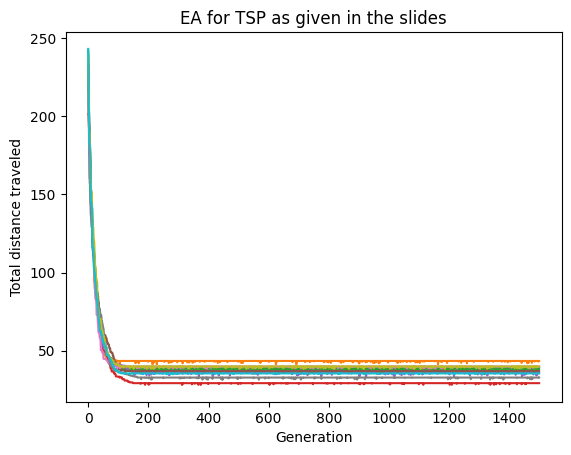

In [93]:
for x in distances:
    plt.plot(x)

plt.xlabel("Generation")
plt.ylabel("Total distance traveled")
plt.title("EA for TSP as given in the slides")
plt.show()

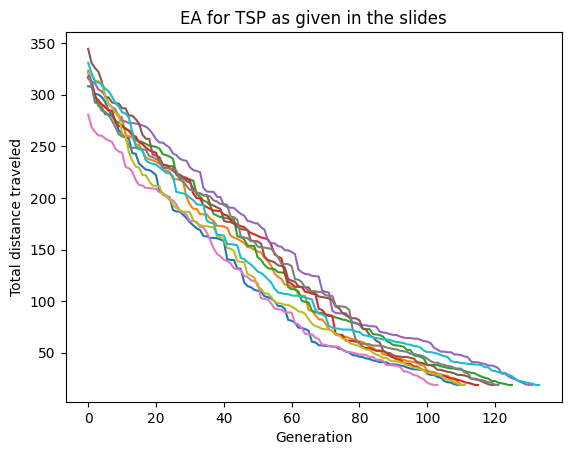

In [94]:
for x in distances_2opt_one_parent:
    plt.plot(x)

plt.xlabel("Generation")
plt.ylabel("Total distance traveled")
plt.title("EA for TSP as given in the slides")
plt.show()

In [104]:
print(distances_2opt_one_parent[0][-1])

18.8374
